In [93]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import calendar
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [94]:
# Carga de datos
data = pd.read_csv('datos_energia.csv', header = 0)
data['Precio'] = data['Precio'].astype('float64')
data['Fecha']  = pd.to_datetime(data['Fecha'])
data.head()

,Fecha,Hora,Precio
0,2001-01-01,0.0,53.72759
1,2001-01-02,0.0,46.72759
2,2001-01-03,0.0,46.72759
3,2001-01-04,0.0,52.72759
4,2001-01-05,0.0,51.72759


In [95]:
# Agrupar por dias y sacar el promedio por dias, agrupar por el dia 
df = data.groupby('Fecha').mean()
df = df.reset_index()
df.head()

,Fecha,Hora,Precio
0,1995-07-20,12.0,1.409435
1,1995-07-21,11.5,4.924333
2,1995-07-22,11.5,1.269500
3,1995-07-23,11.5,0.953083
4,1995-07-24,11.5,4.305917


In [96]:
# Grafica Fecha x Precio
fig = px.line(df, x = 'Fecha', y = 'Precio',
              title = "Precio promedio diario (kws) desde 1996 hasta 2018",
              template = "plotly_dark")
fig.show()

# <center> LSTM

Se aplicara una red neuronal lstm

In [97]:
df2 = df['Precio']
df2.head()

0    1.409435
1    4.924333
2    1.269500
3    0.953083
4    4.305917
Name: Precio, dtype: float64

In [98]:
# Re escalamos los datos para poder ingresar en el modelo ltsm
df3 = df2.values
df3 = df3.astype('float32')
df3 = df3.reshape(-1, 1)
df3

array([[ 1.4094348],
       [ 4.924333 ],
       [ 1.2695   ],
       ...,
       [71.148346 ],
       [64.71012  ],
       [73.972084 ]], dtype=float32)

In [99]:
# Normalizar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range = (0, 1))
df4 = scaler.fit_transform(df3)

In [100]:
# Partir los datos en train y test
# se toma el 80% de train y el 20% 
train_size = int(len(df4) * 0.8)
test_size = len(df4) - train_size
train, test = df4[0:train_size,:], df4[train_size:len(df4),:]

In [101]:
# Verificar la lonitud de los conjuntos
print(len(train)/len(df4), len(test)/len(df4))

0.7999039154455921 0.2000960845544079


In [102]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back = 1):
    '''
    Esta funcion creara una matriz X con las observaciones Yt - lookback 
    y una matriz con el valor actual de Yt
    por defecto look back sera de 1
    '''
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

De la maya construida en colab, se obtuco que el look back optimo es 3

<img src="img1.png">

Por lo que con ayuda de la funcion *create_dataset* se crean la matrices X y Y para entrenar el modelo.

In [103]:
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [104]:
X_train

array([[0.00046836, 0.00227812, 0.00039631],
       [0.00227812, 0.00039631, 0.00023339],
       [0.00039631, 0.00023339, 0.00195971],
       ...,
       [0.06297596, 0.08842015, 0.08694918],
       [0.08842015, 0.08694918, 0.0906342 ],
       [0.08694918, 0.0906342 , 0.08408892]], dtype=float32)

In [105]:
y_train

array([0.00023339, 0.00195971, 0.00033435, ..., 0.0906342 , 0.08408892,
       0.08403245], dtype=float32)

In [106]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [107]:
# Se crea una red neuronal LSTM con doble capa LSTM y look back de 3 y una salida dense 
model = Sequential()
model.add(LSTM(8, return_sequences = True, input_shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))

In [108]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 8)              384       
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________


In [109]:
# Compilador 
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [110]:
# Ajuste del modelo
model_fit = model.fit(X_train, y_train, 
                      epochs = 10, 
                      batch_size = 1, 
                      verbose = 2, 
                      validation_data = (X_test, y_test))

Train on 6656 samples, validate on 1662 samples
Epoch 1/10
 - 18s - loss: 8.7118e-05 - val_loss: 8.0680e-04
Epoch 2/10
 - 15s - loss: 4.0167e-05 - val_loss: 0.0013
Epoch 3/10
 - 14s - loss: 3.8212e-05 - val_loss: 0.0016
Epoch 4/10
 - 13s - loss: 3.6135e-05 - val_loss: 0.0022
Epoch 5/10
 - 15s - loss: 3.4612e-05 - val_loss: 0.0027
Epoch 6/10
 - 13s - loss: 3.3211e-05 - val_loss: 0.0021
Epoch 7/10
 - 14s - loss: 3.3733e-05 - val_loss: 0.0022
Epoch 8/10
 - 13s - loss: 3.2851e-05 - val_loss: 0.0025
Epoch 9/10
 - 15s - loss: 3.2817e-05 - val_loss: 0.0029
Epoch 10/10
 - 16s - loss: 3.2216e-05 - val_loss: 0.0025


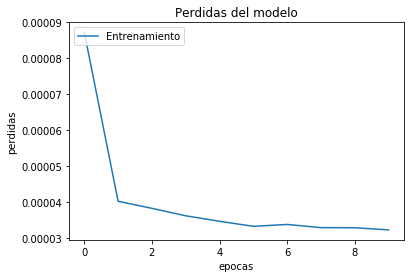

In [111]:
# Grafica de Perdida
plt.plot(model_fit.history['loss'])
#plt.plot(model_fit.history['val_loss'])
plt.title('Perdidas del modelo')
plt.ylabel('perdidas')
plt.xlabel('epocas')
plt.legend(['Entrenamiento', 'test'], loc='upper left')
plt.show()

In [112]:
# Realizar predicciones para calcular el error
train_Predict = model.predict(X_train)
test_Predict = model.predict(X_test)

In [113]:
# retornar los valores predichos a escala original
train_Predict = scaler.inverse_transform(train_Predict)
test_Predict = scaler.inverse_transform(test_Predict)

# retornar los valores reales a la escala original
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [114]:
# Calcular el RSME 
trainScore = math.sqrt(mean_squared_error(y_train[0], train_Predict[:,0]))
print('Train Score: {:.4} RMSE'.format(trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], test_Predict[:,0]))
print('Test Score: {:.4} RMSE'.format(testScore))

Train Score: 11.74 RMSE
Test Score: 97.46 RMSE


In [ ]:
# Ordenar la fecha con las predicciones para graficar

In [122]:
# acomodar valores de training
'''
matriz vacia con la longitud de df4
llena la matriz de nan
ingresa los valores de las predicciones los demas los deja en nan
'''
trainPredictPlot = np.empty_like(df4)                                             
trainPredictPlot[:, :] = np.nan                                                 
trainPredictPlot[look_back:len(train_Predict) + look_back, :] = train_Predict

# acomodar valores de testing
testPredictPlot = np.empty_like(df4)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_Predict) + (look_back*2) + 1:len(df4)-1, :] = test_Predict

In [121]:
# Verificacion de longitudes
print(len(df), len(trainPredictPlot), len(testPredictPlot))

8326 8326 8326


In [129]:
dff = df.loc[:, ['Fecha', 'Precio']]
dff['Precio_train'] = trainPredictPlot
dff['Precio_test'] = testPredictPlot
dff

,Fecha,Precio,Precio_train,Precio_test
0,1995-07-20,1.409435,NaN,NaN
1,1995-07-21,4.924333,NaN,NaN
2,1995-07-22,1.269500,NaN,NaN
3,1995-07-23,0.953083,10.254914,NaN
4,1995-07-24,4.305917,9.455468,NaN
5,1995-07-25,1.149167,11.469420,NaN
6,1995-07-26,1.108625,10.010317,NaN
7,1995-07-27,0.585958,9.498684,NaN
8,1995-07-28,0.499792,8.940486,NaN
9,1995-07-29,0.927667,8.765270,NaN


In [139]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x = dff['Fecha'],
                y = dff['Precio'],
                name = "Precio",
                line_color = 'deepskyblue',
                opacity = 0.8))

fig.add_trace(go.Scatter(
                x = dff['Fecha'],
                y = dff['Precio_train'],
                name = "Train",
                line_color = 'green',
                opacity = 0.8))

fig.add_trace(go.Scatter(
                x = dff['Fecha'],
                y = dff['Precio_test'],
                name = "Test",
                line_color = 'orange',
                opacity = 0.8))

# Use date string to set xaxis range
fig.update_layout(title_text="Precio y predicciones de la energia (kws) ",
                 template = "plotly_dark")
fig.show()